# Forecasting Influenza with Internet Traffic
### Purpose of this notebook
* Explore the feasability of using linear models for epidemiological forecasting
* In specific, to use Wikipedia Pageview logs to train linear models that can forecast weekly ILI in the United States

### TODO:
* Express the DELPHI pageviews dataset as a fracton of the total page views for the project that week
* Perform LASSO regression

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn as sk
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

### Retrieving Relevant Data from Data Store

In [2]:
%%capture
%run influenza-data.ipynb
%store -r pageViews
%store -r lanlPageViews
%store -r wILI

### Create A Normalized Page Views DataFrame
Create a time series containing the number of requests for each week, expressed as a fraction of the projects total requests. (an example of a project is en.wikipedia -- the values are very large)

In [3]:
cols = lanlPageViews.columns
relativePageViews = lanlPageViews.loc[200750:,cols[:-1]].div(lanlPageViews.loc[200750:, 'en'], axis=0)

### Normalizing the page views dataframes

In [4]:
def normalizeDf(df):
    # normalize the page views to a 0-1 scale
    return ( df - df. min() ) / (df.max() - df.min() )

pageViews = normalizeDf(pageViews)
lanlPageViews = normalizeDf(lanlPageViews)

### Finding Most Highly Correlated Articles
Using the Pearson's r coefficient

In [5]:
def correlateArticles(pageViewsDf, wILIdf, s, e):
    # top pearson r coefficients
    correlations = []
    for article in pageViewsDf.columns:
        df = pd.DataFrame({'wILI': wILI.loc[s:e, 'Weekly ILI'],
                           'Views': pageViewsDf.loc[s:e, article]})
        correlations.append( (article, df.corr().loc['Views', 'wILI']))
    correlations.sort(key=lambda t: t[1], reverse=True)
    return correlations

In [6]:
# DELPHI dataset correlations
s, e = pageViews.index[0], pageViews.index[-1]
correlateArticles(pageViews, wILI, s, e)[:5]

[('influenza_a_virus', 0.62190118638311898),
 ('influenza_prevention', 0.42877100952714736),
 ('flu_season', 0.41242541315128961),
 ('influenza', 0.41110924295814455),
 ('influenza_a_virus_subtype_h1n2', 0.40264204754006272)]

In [7]:
# LANL dataset correlations
s, e = lanlPageViews.index[0], lanlPageViews.index[-1]
correlateArticles(lanlPageViews, wILI, 200750, 201401)[:5]

[('influenza_a_virus', 0.59402423130968529),
 ('common_cold', 0.45560158009905971),
 ('influenza_prevention', 0.4499103911003472),
 ('flu_season', 0.4352735105043477),
 ('influenza_a_virus_subtype_h1n2', 0.42699022970183853)]

### Removing the 2009 Flu Pandemic Data
The pandemic resulted in an unusual increase in flu related searches, which decreases the accuracy of the model.
This occured between 
> epiweeks 200909 - 200952

In [8]:
pandemicEpiweeks = list(range(200914, 200940))
pageViewsFiltered = pageViews.drop(pandemicEpiweeks)
lanlPageViewsFiltered = lanlPageViews.drop(pandemicEpiweeks)
relativePageViewsFiltered = relativePageViews.drop(pandemicEpiweeks)
wILIfiltered = wILI.drop(pandemicEpiweeks)

In [9]:
pageViewsFiltered.loc[201250:201310].index

Int64Index([201250, 201251, 201252, 201301, 201302, 201303, 201304, 201305,
            201306, 201307, 201308, 201309, 201310],
           dtype='int64')

In [10]:
correlateArticles(pageViewsFiltered, wILIfiltered, 200801, 201401)[:5]

[('human_flu', 0.8559073384318262),
 ('influenzavirus_a', 0.75646761376852156),
 ('influenzavirus_c', 0.74632089757026099),
 ('oseltamivir', 0.73642409239939188),
 ('influenza', 0.67814647192668143)]

In [11]:
correlateArticles(lanlPageViewsFiltered, wILIfiltered, 200801, 201401)[:5]

[('human_flu', 0.85716166043635189),
 ('influenzavirus_a', 0.75635957497415285),
 ('influenzavirus_c', 0.74900782524929277),
 ('oseltamivir', 0.73661257456932394),
 ('influenza', 0.67776258367473075)]

In [12]:
correlateArticles(relativePageViewsFiltered, wILIfiltered, 200801, 201401)[:5]

[('human_flu', 0.87629400815946001),
 ('influenza', 0.82017016314696567),
 ('influenzavirus_c', 0.79534428942405599),
 ('oseltamivir', 0.76042772035906914),
 ('influenzavirus_a', 0.71107611633646028)]

### Removing the 2013 preseason
> epiweeks 201251-201305

In [13]:
preseasonEpiweeks = list(pageViewsFiltered.loc[201250:201310].index)
pageViewsFiltered = pageViewsFiltered.drop(preseasonEpiweeks)
lanlPageViewsFiltered = lanlPageViewsFiltered.drop(preseasonEpiweeks)
relativePageViewsFiltered = relativePageViewsFiltered.drop(preseasonEpiweeks)
wILIfiltered = wILIfiltered.drop(preseasonEpiweeks)

In [14]:
correlateArticles(pageViewsFiltered, wILIfiltered, 200801, 201401)[:5]

[('human_flu', 0.87586520439712767),
 ('influenzavirus_a', 0.82099611576750731),
 ('influenzavirus_c', 0.73026319436724652),
 ('oseltamivir', 0.70672459078000172),
 ('influenza', 0.67298208185697916)]

In [15]:
correlateArticles(lanlPageViewsFiltered, wILIfiltered, 200801, 201401)[:5]

[('human_flu', 0.87710336101242525),
 ('influenzavirus_a', 0.82087560743103416),
 ('influenzavirus_c', 0.73345018010156426),
 ('oseltamivir', 0.7070102381335166),
 ('influenza', 0.67285342021943306)]

In [16]:
correlateArticles(relativePageViewsFiltered, wILIfiltered, 200801, 201401)[:5]

[('human_flu', 0.9004214674426515),
 ('influenza', 0.82273559360988779),
 ('influenzavirus_c', 0.80300494604184325),
 ('influenzavirus_a', 0.79380337546619106),
 ('neuraminidase_inhibitor', 0.73116913715345544)]

### Conclusions about the data
* Filtering out the noisy 2009 flu pandemic and 2013 preseason increases the correlation of the data.
* Expressing the page views as a fraction of the project's total views further increases the correlation of the data. 

### Simple Linear Regression Nowcast On Each Article
For a nowcast, the page view timeseries is not timeshifted at all. Whereas in a 1 week forcast, 
we timeshift the page view timeseries one week (e.g. 200801 --> 200802)

In [17]:
def simpleLinearRegression(pageViewsDf, wILIdf, train_s, train_e, test_s, test_e, forecastOffset):
    """
    Run a simple single variable linear regr. on between an articles page views and wILI.
    The forecast offset is how many weeks in advance you want to predict
    """
    results = pd.DataFrame(index=pageViewsDf.columns)
    # doing this shift will assign the previous weeks views the the curr weeks index
    shftedPageViews = pageViewsDf.shift(forecastOffset)
    for article in pageViewsDf.columns:
        X_train = shftedPageViews.loc[train_s:train_e, [article]]
        X_test = shftedPageViews.loc[test_s:test_e, [article]]
        
        Y_train = wILIdf.loc[train_s:train_e]
        y_true = wILIdf.loc[test_s:test_e]
        
        # run the regression & evaluate
        regr = linear_model.LinearRegression()
        regr.fit(X_train, Y_train)
        
        y_pred = regr.predict(X_test)
        
        MSE =  np.mean((regr.predict(X_test) - y_true) ** 2)[0]
        r2  = r2_score(y_true, y_pred)
        
        results.loc[article, 'MSE'] = MSE
        results.loc[article, 'R2'] = r2
        
    return results.sort_values('R2', ascending=False)

In [28]:
res = simpleLinearRegression(pageViewsFiltered, wILIfiltered, train_s=200801, train_e=201401, 
                       test_s=201401, test_e=201652, forecastOffset=1)
print('Top 3 Simp. LR results from DELPHI pageviews df')
res[:3]

Top 3 Simp. LR results from DELPHI pageviews df


,MSE,R2
influenza_a_virus,0.455013,0.506797
oseltamivir,0.637085,0.309443
influenza_a_virus_subtype_h3n2,0.643768,0.302200


In [29]:
res = simpleLinearRegression(pageViewsFiltered, wILIfiltered, train_s=200751, train_e=201152, 
                       test_s=201201, test_e=201408, forecastOffset=0)
print('Top 3 Simp. LR results from QUAC pageviews df')
res[:3]

Top 3 Simp. LR results from QUAC pageviews df


,MSE,R2
human_flu,0.276378,0.473883
oseltamivir,0.386100,0.265014
influenza_a_virus_subtype_h1n1,0.410433,0.218694


In [30]:
res = simpleLinearRegression(relativePageViewsFiltered, wILIfiltered, train_s=200751, train_e=201152, 
                       test_s=201201, test_e=201408, forecastOffset=0)
print('Top 5 Simp. LR results from LANL relative pageviews df')
res[:5]

Top 5 Simp. LR results from LANL relative pageviews df


,MSE,R2
human_flu,0.201473,0.616473
oseltamivir,0.300775,0.427441
influenzavirus_c,0.313682,0.402871
viral_pneumonia,0.352165,0.329614
influenza_a_virus_subtype_h1n1,0.378586,0.279319


### Multiple Linear Regression Nocast On Most Highly Correlated Articles

In [31]:
def multipleLinearRegression(pageViewsDf, wILIdf, train_s, train_e, test_s, test_e, forecastOffset, articles):
    """
    Learn a multiple linear regression model on the articles passed in, from train_s to train_e.
    """
    result = pd.DataFrame()
    # doing this shift will assign the previous weeks views the the curr weeks index
    shftedPageViews = pageViewsDf.shift(forecastOffset)
    
    X_train = shftedPageViews.loc[train_s:train_e, articles]
    X_test = shftedPageViews.loc[test_s:test_e, articles]
    
    Y_train = wILIdf.loc[train_s:train_e]
    y_true = wILIdf.loc[test_s:test_e]

    print('Training from:', train_s, 'to', train_e, 'for a total of', len(X_train), ' weeks')
    print('Testing from', test_s, 'to', test_e, 'for a total of', len(X_test), ' weeks')
    totalSamples = len(X_train) + len(X_test)
    trainPct = int((len(X_train) / totalSamples)*100)
    print('Split:', trainPct, '/', 100-trainPct)
    # run the regression & evaluate
    regr = linear_model.LinearRegression()
    regr.fit(X_train, Y_train)
    y_pred = regr.predict(X_test)

    MSE =  np.mean((y_pred - y_true) ** 2)[0]
    r2 = r2_score(y_true, y_pred)
        
    result.loc['Result', 'MSE'] = MSE
    result.loc['Result', 'R2'] = r2
        
    return result, y_true, y_pred

Training from: 200801 to 201226 for a total of 209  weeks
Testing from 201226 to 201401 for a total of 67  weeks
Split: 75 / 25
Mult. LR results from DELPHI pageviews df w/ top 10 correlated articles


,MSE,R2
Result,0.257878,0.498668


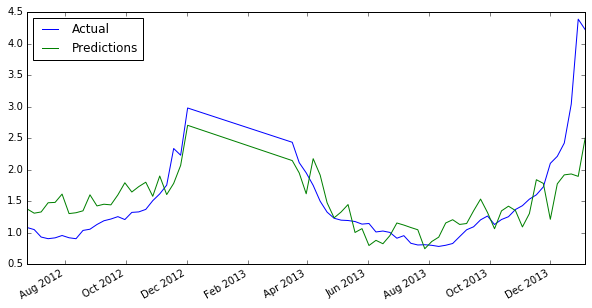

In [32]:
train_s, train_e = 200801, 201226
test_s, test_e = 201226, 201401
# top correlated articles by pearson coef
topArticlesAllYears = [ t[0] for t in correlateArticles(relativePageViewsFiltered, wILIfiltered, train_s, train_e)[:5] ]
topArticlesTraining = [ t[0] for t in correlateArticles(relativePageViewsFiltered, wILIfiltered, train_s, train_e)[:5] ]

res, y_true, y_pred = multipleLinearRegression(pageViewsFiltered, wILIfiltered, train_s=train_s, train_e=train_e, 
                               test_s=test_s, test_e=test_e, forecastOffset=0, articles=topArticlesTraining)

index = list( map(epiweekToDatetime, list(pageViewsFiltered.loc[test_s:test_e].index)) )

y = pd.DataFrame({'Actual': y_true.values.reshape(len(y_true)), 
                  'Predictions': y_pred.reshape(len(y_pred))}, 
                  index=index )

y.plot(figsize=(10,5))
print('Mult. LR results from DELPHI pageviews df w/ top 10 correlated articles')
res

Training from: 201101 to 201320 for a total of 111  weeks
Testing from 201321 to 201409 for a total of 41  weeks
Split: 73 / 27
Mult. LR results from QUAC pageviews df w/ top 10 correlated articles


,MSE,R2
Result,0.139564,0.853059


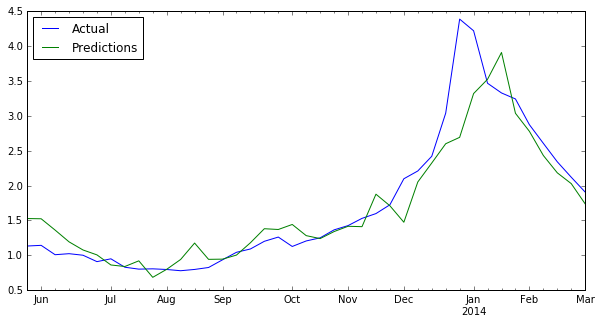

In [33]:
train_s, train_e = 201101, 201320
test_s, test_e = 201321, 201409

top10Articles = [ t[0] for t in correlateArticles(lanlPageViews, wILI, 200750, 201152)[:5] ]

res, y_true, y_pred = multipleLinearRegression(lanlPageViewsFiltered, wILIfiltered, train_s=train_s, train_e=train_e, 
                       test_s=test_s, test_e=test_e, forecastOffset=0, articles=top10Articles)

index = list( map(epiweekToDatetime, list(lanlPageViewsFiltered.loc[test_s:test_e].index)) )

y = pd.DataFrame({'Actual': y_true.values.reshape(len(y_true)), 
                  'Predictions': y_pred.reshape(len(y_pred))}, 
                  index=index )

y.plot(figsize=(10,5))
print('Mult. LR results from QUAC pageviews df w/ top 10 correlated articles')
res[:5]

### In progress

In [34]:
def lassoRegression(pageViewsDf, wILIdf, train_s, train_e, test_s, test_e, forecastOffset, articles):
    """
    Learn a multiple linear regression model on the articles passed in, from train_s to train_e.
    """
    result = pd.DataFrame()
    # doing this shift will assign the previous weeks views the the curr weeks index
    shftedPageViews = pageViewsDf.shift(forecastOffset)
    
    X_train = shftedPageViews.loc[train_s:train_e, articles]
    X_test = shftedPageViews.loc[test_s:test_e, articles]
    
    Y_train = wILIdf.loc[train_s:train_e]
    y_true = wILIdf.loc[test_s:test_e]

    print('Training from:', train_s, 'to', train_e, 'for a total of', len(X_train), ' weeks')
    print('Testing from', test_s, 'to', test_e, 'for a total of', len(X_test), ' weeks')
    totalSamples = len(X_train) + len(X_test)
    trainPct = int((len(X_train) / totalSamples)*100)
    print('Split:', trainPct, '/', 100-trainPct)
    # run the regression & evaluate
    regr = linear_model.Lasso(alpha=0.1)
    regr.fit(X_train, Y_train)
    y_pred = regr.predict(X_test)

    MSE =  np.mean((y_pred - y_true) ** 2)[0]
    r2 = r2_score(y_true, y_pred)
        
    result.loc['Result', 'MSE'] = MSE
    result.loc['Result', 'R2'] = r2
        
    return result, y_true, y_pred